First we are going to preprocess the data then create the model:

# Step 0: Import Dataset
I will use the `Sales_ethereum.csv` dataset, which contains on-chain data related to sales in Decentraland.

In [1]:
import pandas as pd
import numpy as np
sales_ethereum = pd.read_csv("../dataset/IITP-VDLand/Sales_ethereum.csv")
sales_ethereum.head()

,from_address,to_address,token_id,transaction_hash,log_index,block_timestamp,block_number,block_hash,nonce,transaction_index,...,gas,gas_price,input,receipt_cumulative_gas_used,receipt_gas_used,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price,Method
0,0x13936d1369dda5bd295d24bb69dae4e3c6586312,0x8059cec671f5ced8ee8668b34d4625f62229cc98,40493601663591677152141578284380417163164,0xc573da5559467bd2b392afa03dc9589f3ed34a19f8e6...,211.0,2023-06-23 06:53:59 UTC,17540621,0x0661dd90a8ae56440c8ca46a039e932c9c0d3e4d3ffa...,117,136.0,...,225954,11876376480,0xae7b0333000000000000000000000000f87e31492faf...,10790201.0,177892.0,1.685342e+10,1.000000e+08,2.0,1.187638e+10,Execute Order
1,0xa761f6559abe480bdc37944ae822a527c55f4d18,0x51bb8c0cac58e4e2a68a709e2f04b6f515880c33,14291859410679415465461733512134264881047,0x144a131017c8c98977aaad20a7ef00993006222e362f...,274.0,2021-03-09 22:54:28 UTC,12007120,0x31884e38b15d764dfff49d1af56532d1353696fd0e04...,127,130.0,...,269311,100000000000,0xae7b0333000000000000000000000000f87e31492faf...,9866165.0,138325.0,NaN,NaN,NaN,1.000000e+11,Execute Order
2,0xdfe9e4170953bd73be4a68411aa4707850f16ce3,0x91409e181a8b1cf04535ed057eba13b12161927c,23479483317544753978972847912792006590430,0xf9951ad1aae60c58b7dba048744e59c99f66e782f02c...,48.0,2018-12-06 05:41:42 UTC,6834871,0x7145ee877c241b0c1216e95390d1fe1f717aeaa2ae62...,12,54.0,...,357705,7000000000,0xae7b0333000000000000000000000000f87e31492faf...,2494152.0,113326.0,NaN,NaN,NaN,7.000000e+09,Execute Order
3,0x3af9944b104dd9abce2cb4239d6f93a7d38187ea,0x5ce213893956bbf4249a7f8a079331280065eec6,1157920892373161954235709850086879078294502189...,0xfce5c9613cab7cb4c16c3461f7d6fc45790f205035ae...,221.0,2021-08-23 01:59:38 UTC,13078782,0xfc28430969a25f1c1b2ec708a514c2e3b7da66caa6f9...,191,112.0,...,383980,36008677880,0xab834bab0000000000000000000000007be8076f4ea4...,11865437.0,271328.0,6.036366e+10,1.500000e+09,2.0,3.600868e+10,Atomic Match_
4,0xa01424b7540adbb792375dcf97b733a5d68ad347,0x0903ba1e13c598646e0438e55c9914490231adb5,1157920892373161954235709850086879078311516308...,0x8fdfa33cb79a44d6789562b16294e0cc2e74f27b4bc0...,40.0,2022-05-09 14:24:25 UTC,14742910,0x7cc42d968840beaad8914b94b123bf6c725f96949131...,1,48.0,...,241893,47022665000,0xae7b0333000000000000000000000000f87e31492faf...,2777917.0,186004.0,5.718854e+10,1.500000e+09,2.0,4.702266e+10,Execute Order


In [2]:
# Hyper parameters that effect the results and can be used for tuning the models
NUMBER_OF_WALKS = 10
WALK_LENGHT = 80
RANDOM_WALK_P = 1
RANDOM_WALK_Q = 0.8
PRICE_TIMESTAMP_ALPHA = 0.7
# Labeling parameters for the second approach
LABELING_HIGH_VALUE_TRANSACTION_THRESHOLD = 1 * (10**18)  # 1 ETH
LABELING_FREQUENT_TRANSACTIONS_THRESHOLD = 100  # Frequent transactions threshold
LABELING_PERCENTILE_GAS_PRICE = 99  # Percentile for gas price anomalies

# Step 1: Filtering and Normalizing
Filtering the columns we need, converting them to the required format and normalizing them.

In [3]:
sales_ethereum_filtered = sales_ethereum[["from_address","to_address","block_timestamp","gas_price","value_in_wei"]]
sales_ethereum_filtered.head()

,from_address,to_address,block_timestamp,gas_price,value_in_wei
0,0x13936d1369dda5bd295d24bb69dae4e3c6586312,0x8059cec671f5ced8ee8668b34d4625f62229cc98,2023-06-23 06:53:59 UTC,11876376480,0
1,0xa761f6559abe480bdc37944ae822a527c55f4d18,0x51bb8c0cac58e4e2a68a709e2f04b6f515880c33,2021-03-09 22:54:28 UTC,100000000000,0
2,0xdfe9e4170953bd73be4a68411aa4707850f16ce3,0x91409e181a8b1cf04535ed057eba13b12161927c,2018-12-06 05:41:42 UTC,7000000000,0
3,0x3af9944b104dd9abce2cb4239d6f93a7d38187ea,0x5ce213893956bbf4249a7f8a079331280065eec6,2021-08-23 01:59:38 UTC,36008677880,0
4,0xa01424b7540adbb792375dcf97b733a5d68ad347,0x0903ba1e13c598646e0438e55c9914490231adb5,2022-05-09 14:24:25 UTC,47022665000,0


In [4]:
from datetime import datetime, timezone

# Function to safely convert timestamps and handle invalid formats
def safe_convert_timestamp(timestamp_str):
    try:
        # Attempt conversion using the desired format
        return datetime.strptime(timestamp_str, "%Y-%m-%d %H:%M:%S %Z").replace(tzinfo=timezone.utc).timestamp()
    except ValueError:
        try:
            # Handle cases where timezone info is missing
            return datetime.strptime(timestamp_str, "%Y-%m-%d %H:%M:%S").replace(tzinfo=timezone.utc).timestamp()
        except ValueError:
            # Return None for invalid formats
            return None

# Apply the conversion function to create a new column
sales_ethereum_filtered['converted_timestamp'] = sales_ethereum_filtered['block_timestamp'].map(safe_convert_timestamp)

# Filter out rows with invalid timestamps (None)
sales_ethereum_filtered = sales_ethereum_filtered[sales_ethereum_filtered['converted_timestamp'].notnull()]

# View the results
sales_ethereum_filtered.head()

/var/folders/kg/hbb2bcm97yv0w0ynbzkqg49w0000gp/T/ipykernel_76457/1165381913.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_ethereum_filtered['converted_timestamp'] = sales_ethereum_filtered['block_timestamp'].map(safe_convert_timestamp)


,from_address,to_address,block_timestamp,gas_price,value_in_wei,converted_timestamp
0,0x13936d1369dda5bd295d24bb69dae4e3c6586312,0x8059cec671f5ced8ee8668b34d4625f62229cc98,2023-06-23 06:53:59 UTC,11876376480,0,1.687503e+09
1,0xa761f6559abe480bdc37944ae822a527c55f4d18,0x51bb8c0cac58e4e2a68a709e2f04b6f515880c33,2021-03-09 22:54:28 UTC,100000000000,0,1.615330e+09
2,0xdfe9e4170953bd73be4a68411aa4707850f16ce3,0x91409e181a8b1cf04535ed057eba13b12161927c,2018-12-06 05:41:42 UTC,7000000000,0,1.544075e+09
3,0x3af9944b104dd9abce2cb4239d6f93a7d38187ea,0x5ce213893956bbf4249a7f8a079331280065eec6,2021-08-23 01:59:38 UTC,36008677880,0,1.629684e+09
4,0xa01424b7540adbb792375dcf97b733a5d68ad347,0x0903ba1e13c598646e0438e55c9914490231adb5,2022-05-09 14:24:25 UTC,47022665000,0,1.652106e+09


In [5]:
from sklearn.preprocessing import MinMaxScaler
# Normalize timestamps using MinMaxScaler
scaler = MinMaxScaler()
sales_ethereum_filtered['block_timestamp_normalized'] = scaler.fit_transform(sales_ethereum_filtered[['converted_timestamp']])
sales_ethereum_filtered.head()

,from_address,to_address,block_timestamp,gas_price,value_in_wei,converted_timestamp,block_timestamp_normalized
0,0x13936d1369dda5bd295d24bb69dae4e3c6586312,0x8059cec671f5ced8ee8668b34d4625f62229cc98,2023-06-23 06:53:59 UTC,11876376480,0,1.687503e+09,0.935390
1,0xa761f6559abe480bdc37944ae822a527c55f4d18,0x51bb8c0cac58e4e2a68a709e2f04b6f515880c33,2021-03-09 22:54:28 UTC,100000000000,0,1.615330e+09,0.528768
2,0xdfe9e4170953bd73be4a68411aa4707850f16ce3,0x91409e181a8b1cf04535ed057eba13b12161927c,2018-12-06 05:41:42 UTC,7000000000,0,1.544075e+09,0.127312
3,0x3af9944b104dd9abce2cb4239d6f93a7d38187ea,0x5ce213893956bbf4249a7f8a079331280065eec6,2021-08-23 01:59:38 UTC,36008677880,0,1.629684e+09,0.609636
4,0xa01424b7540adbb792375dcf97b733a5d68ad347,0x0903ba1e13c598646e0438e55c9914490231adb5,2022-05-09 14:24:25 UTC,47022665000,0,1.652106e+09,0.735963


In [6]:
# Normalize gas_price using MinMaxScaler
sales_ethereum_filtered['gas_price_normalized'] = scaler.fit_transform(sales_ethereum_filtered[['gas_price']])
sales_ethereum_filtered.head()

,from_address,to_address,block_timestamp,gas_price,value_in_wei,converted_timestamp,block_timestamp_normalized,gas_price_normalized
0,0x13936d1369dda5bd295d24bb69dae4e3c6586312,0x8059cec671f5ced8ee8668b34d4625f62229cc98,2023-06-23 06:53:59 UTC,11876376480,0,1.687503e+09,0.935390,0.001913
1,0xa761f6559abe480bdc37944ae822a527c55f4d18,0x51bb8c0cac58e4e2a68a709e2f04b6f515880c33,2021-03-09 22:54:28 UTC,100000000000,0,1.615330e+09,0.528768,0.016601
2,0xdfe9e4170953bd73be4a68411aa4707850f16ce3,0x91409e181a8b1cf04535ed057eba13b12161927c,2018-12-06 05:41:42 UTC,7000000000,0,1.544075e+09,0.127312,0.001100
3,0x3af9944b104dd9abce2cb4239d6f93a7d38187ea,0x5ce213893956bbf4249a7f8a079331280065eec6,2021-08-23 01:59:38 UTC,36008677880,0,1.629684e+09,0.609636,0.005935
4,0xa01424b7540adbb792375dcf97b733a5d68ad347,0x0903ba1e13c598646e0438e55c9914490231adb5,2022-05-09 14:24:25 UTC,47022665000,0,1.652106e+09,0.735963,0.007771


# Step 2: Create Edge Weights
Create a new column for edge weights using a weighted combination of `gas_price_normalized` and `block_timestamp_normalized`:

In [7]:
# Define alpha for balancing
alpha = PRICE_TIMESTAMP_ALPHA

# Combine gas price and timestamp into a single edge weight
sales_ethereum_filtered['edge_weight'] = (
    alpha * sales_ethereum_filtered['gas_price_normalized'] +
    (1 - alpha) * sales_ethereum_filtered['block_timestamp_normalized']
)

# Step 3: Graph Construction
Construct a directed, weighted graph:

In [8]:
import networkx as nx

# Initialize a directed graph
G = nx.DiGraph()

# Add edges from the DataFrame
for _, row in sales_ethereum_filtered.iterrows():
    G.add_edge(row['from_address'], row['to_address'], weight=row['edge_weight'])


# Step 4: Apply GTN2vec Algorithm
To implement the GTN2vec algorithm, we will perform biased random walks on the graph and generate node sequences.

## 1. Define Transition Probabilities
Calculate transition probabilities for the random walk. This involves using the `p` (return parameter), `q` (exploration parameter), and edge weights.

In [9]:
def calculate_transition_probability(G, p, q, alpha):
    transition_probs = {}
    for node in G.nodes():
        transition_probs[node] = {}
        neighbors = list(G.neighbors(node))
        for neighbor in neighbors:
            weights = []
            for target in G.neighbors(neighbor):
                weight = G[neighbor][target]['weight']
                d = 0 if target == node else (1 if target in neighbors else 2)
                weights.append(weight * (1/p if d == 0 else (1 if d == 1 else 1/q)))
            weights = np.array(weights) / np.sum(weights)
            transition_probs[node][neighbor] = weights
    return transition_probs

# Parameters for random walk
p = RANDOM_WALK_P  # Return parameter
q = RANDOM_WALK_Q  # Exploration parameter
transition_probs = calculate_transition_probability(G, p, q, alpha)


## 2. Perform Biased Random Walk
Simulate random walks on the graph using the transition probabilities.

In [10]:
import random

def random_walk(G, start_node, walk_length, transition_probs):
    walk = [start_node]
    while len(walk) < walk_length:
        cur_node = walk[-1]
        neighbors = list(G.neighbors(cur_node))
        if not neighbors:
            break
        if len(walk) == 1:  # First step
            next_node = random.choice(neighbors)
        else:
            prev_node = walk[-2]
            prob_distribution = transition_probs[prev_node][cur_node]
            next_node = random.choices(neighbors, weights=prob_distribution, k=1)[0]
        walk.append(next_node)
    return walk

# Example: Perform a random walk
start_node = list(G.nodes())[0]
walk_length = 10
sample_walk = random_walk(G, start_node, walk_length, transition_probs)
print("Sample walk:", sample_walk)

Sample walk: ['0x13936d1369dda5bd295d24bb69dae4e3c6586312', '0x13ad7f423e41e097e335dbe59831cadf4ee89d00']


## 3. Generate Walks for All Nodes
Generating multiple random walks for each node.

In [11]:
def generate_walks(G, num_walks, walk_length, transition_probs):
    walks = []
    for _ in range(num_walks):
        for node in G.nodes():
            walk = random_walk(G, node, walk_length, transition_probs)
            walks.append(walk)
    return walks

# Parameters for walks
num_walks = NUMBER_OF_WALKS  # Number of walks per node
walk_length = WALK_LENGHT  # Length of each walk

# Generate walks
walks = generate_walks(G, num_walks, walk_length, transition_probs)
print("Generated walks:", walks[:5])  # Print first 5 walks

Generated walks: [['0x13936d1369dda5bd295d24bb69dae4e3c6586312', '0x98bd1df01f09efc5352596868fc7f11f8479b39e'], ['0x8059cec671f5ced8ee8668b34d4625f62229cc98'], ['0xa761f6559abe480bdc37944ae822a527c55f4d18', '0x24112123ab693e23e6e84b6c85f6ccb71cb9ee34'], ['0x51bb8c0cac58e4e2a68a709e2f04b6f515880c33', '0x7103a727dd976fcb389921ceb148d2ea03e484b6', '0x59b9339a8a3d78a5ffbc86998c85f3c07fa4b1b2', '0x2bdc3644d529e078b42f7115564f37a515e4ee25', '0x7801c1ba42e1e9ae13c0b1c957b01b25312dac16'], ['0xdfe9e4170953bd73be4a68411aa4707850f16ce3', '0x31b415f5213d0c383d859e908c32882c807c4c32']]


## 4. Convert Walks to Node Embeddings
Using the Skip-gram model (via `gensim`) to learn embeddings from the random walks.

In [12]:
from gensim.models import Word2Vec

# Train Word2Vec model on walks
model = Word2Vec(sentences=walks, vector_size=128, window=5, min_count=1, sg=1, workers=4)

# Get embeddings
node_embeddings = {node: model.wv[str(node)] for node in G.nodes()}
print("Embedding for a node:", node_embeddings[start_node])

Embedding for a node: [ 0.274076   -0.22307949  0.49061143  0.08950195  0.6215548  -0.46731144
  0.21804397  0.0951509  -0.35093907 -0.09627689  0.50047165 -0.1850255
 -0.10929799 -0.2107364   0.30659398  0.23802342 -0.09598854 -0.03720885
 -0.03909047  0.44145375  0.31959876  0.24776912 -0.15827532 -0.14771256
 -0.3988783   0.5009613  -0.01441918  0.3955986   0.32369503 -0.08982624
 -0.4069834   0.08380968 -0.18239193  0.08488483 -0.26214486  0.00082085
  0.18600923  0.3927765   0.252137    0.04965736  0.17795058  0.28568
 -0.19927458  0.2633163   0.5272185   0.27996278  0.15379424 -0.08885271
 -0.04689237  0.24884632 -0.02321495  0.08339341  0.40162846  0.25968748
  0.00068699  0.12943716  0.61452854 -0.01240338 -0.2290815  -0.18670788
  0.10149286 -0.3290671   0.332894   -0.04181794  0.3377402  -0.3739305
  0.10886108  0.0477011   0.11805135 -0.25484675  0.01994647 -0.4167381
 -0.49281412 -0.29283106  0.06270057  0.00388179 -0.04513835 -0.07415392
 -0.3518852   0.29419073 -0.2204736

# Step 5: Train Classifier
To train a supervised classifier, we need labeled data, meainign that we need to have a column called `is_money_launderer` in the original dataset (1 for dodgy nodes, 0 for normal nodes).


### 5.1 Approach One: Merge With Labeled Sources (failed)
As an initial approach to labeling the data, I explored Ethereum-labeled transaction datasets. Using Kaggle as a source, I identified two datasets and merged the flagged accounts from both:

In [13]:
# Source 1:
# https://www.kaggle.com/datasets/hamishhall/labelled-ethereum-addresses?resource=download
labeled_addresses = pd.read_csv("../dataset/kaggle_labeled_addresses/eth_addresses.csv")[["Address","Account Type","Label"]]
is_dodgy = labeled_addresses[labeled_addresses['Label'] == 'Dodgy']['Address']
is_dodgy

2153     0xf2effc1cd320ff062bae8649d150dbea3cb6b189
2505     0x0f598112679b78e17a4a9febc83703710d33489c
2560     0x226c98fba127213154a121e9ebcfe73236e6f0dd
2608     0xf31b4f7550833a746f788b36f2b292e5fa49a248
2845     0x870cbbd204d5e2317c60374888e4b6be3bfa092b
                            ...                    
19132    0xef5da7752c084df1cc719c64bbe06fa98b2c554c
19133    0xefa1994328e59f8e24d85458810d67a27289679a
19134    0xf6c68965cdc903164284b482ef5dfdb640d9e0de
19135    0xf6e51ae30705cd7248d4d9ac602cb58cc4b61a52
19137    0xfd2b3eb22bac1634f8b554a6d67fd11849dc3a0f
Name: Address, Length: 5212, dtype: object

In [14]:
# source 2:
# https://www.kaggle.com/datasets/vagifa/ethereum-frauddetection-dataset
labeled_addresses2 = pd.read_csv("../dataset/kaggle_labeled_addresses/transaction_dataset.csv")[["Address","FLAG"]]
is_dodgy2 = labeled_addresses2[labeled_addresses2['FLAG'] != 0]['Address']
is_dodgy2

7662    0x0020731604c882cf7bf8c444be97d17b19ea4316
7663    0x002bf459dc58584d58886169ea0e80f3ca95ffaf
7664    0x002f0c8119c16d310342d869ca8bf6ace34d9c39
7665    0x0059b14e35dab1b4eee1e2926c7a5660da66f747
7666    0x005b9f4516f8e640bbe48136901738b323c53b00
                           ...                    
9836    0xff481ca14e6c16b79fc8ab299b4d2387ec8ecdd2
9837    0xff718805bb9199ebf024ab6acd333e603ad77c85
9838    0xff8e6af02d41a576a0c82f7835535193e1a6bccc
9839    0xffde23396d57e10abf58bd929bb1e856c7718218
9840    0xd624d046edbdef805c5e4140dce5fb5ec1b39a3c
Name: Address, Length: 2179, dtype: object

In [15]:
# Combine the lists into a single DataFrame or Series
all_dodgy_addresses = pd.concat([is_dodgy, is_dodgy2])

# Remove duplicates to create a list of unique addresses
is_money_launderer = all_dodgy_addresses.drop_duplicates().reset_index(drop=True)

# Display the result
print(f"Total unique dodgy addresses: {len(is_money_launderer)}")
is_money_launderer.head()

Total unique dodgy addresses: 5390


0    0xf2effc1cd320ff062bae8649d150dbea3cb6b189
1    0x0f598112679b78e17a4a9febc83703710d33489c
2    0x226c98fba127213154a121e9ebcfe73236e6f0dd
3    0xf31b4f7550833a746f788b36f2b292e5fa49a248
4    0x870cbbd204d5e2317c60374888e4b6be3bfa092b
Name: Address, dtype: object

In [16]:
# Combine from_address and to_address into a unique set
sales_addresses = set(sales_ethereum_filtered['from_address']).union(
    set(sales_ethereum_filtered['to_address'])
)

# Convert is_money_launderer to a set
dodgy_addresses_set = set(is_money_launderer)

# Find overlapping addresses
overlapping_addresses = dodgy_addresses_set.intersection(sales_addresses)

# Print the results
print(f"Number of overlapping addresses: {len(overlapping_addresses)}")
print("Sample overlapping addresses:", list(overlapping_addresses)[:5])

Number of overlapping addresses: 0
Sample overlapping addresses: []


As shown above, I formed a list of 5,390 unique suspicious wallets/contracts. However, there is no overlap between the IITP-VDLand dataset and these addresses.

### 5.2 Approach two: Heuristic-Based Labeling (Preliminary Results)
Using heuristics to label accounts. For instance we used:
- High-value transactions: Addresses with unusually high value_in_wei could be flagged as potentially suspicious.
- Frequent transactions: Addresses with excessive transactions in a short period could be flagged.
- Gas price anomalies: Transactions with unusually high gas prices might be laundering attempts.

#### Step 1: Define Thresholds for Heuristics

Set thresholds for labeling based on your specified criteria:

1. High-Value Transactions:
   - Flag transactions with `value_in_wei` above a threshold (e.g., 10^18 wei, equivalent to 1 ETH).

2. Frequent Transactions:
   - Count transactions for each address within a specified timeframe (e.g., a day). Flag addresses with excessive transactions.

3. Gas Price Anomalies:
   - Flag transactions with `gas_price` above a threshold (e.g., an unusually high percentile like the 99th percentile).


#### Step 2: Apply Heuristics to Label Data

I adjusted `high_value_threshold`, `transaction_count_threshold`, `gas_price_percentile` in a way to make the number of `1` and `0` reasonable.

In [17]:

# Step 1: Convert columns to numeric and handle invalid values
sales_ethereum_filtered['value_in_wei'] = pd.to_numeric(sales_ethereum_filtered['value_in_wei'], errors='coerce')
sales_ethereum_filtered['gas_price'] = pd.to_numeric(sales_ethereum_filtered['gas_price'], errors='coerce')

# Drop rows with missing values in critical columns
sales_ethereum_filtered = sales_ethereum_filtered.dropna(subset=['value_in_wei', 'gas_price'])

# Step 2: Define thresholds for heuristics
high_value_threshold = LABELING_HIGH_VALUE_TRANSACTION_THRESHOLD
transaction_count_threshold = LABELING_FREQUENT_TRANSACTIONS_THRESHOLD
gas_price_percentile = LABELING_PERCENTILE_GAS_PRICE

# Step 3: Apply heuristics
# High-value transactions
sales_ethereum_filtered['high_value_flag'] = sales_ethereum_filtered['value_in_wei'] > high_value_threshold

# Frequent transactions
# Count the number of transactions for each 'from_address'
transaction_counts = sales_ethereum_filtered['from_address'].value_counts()
frequent_addresses = transaction_counts[transaction_counts > transaction_count_threshold].index
sales_ethereum_filtered['frequent_flag'] = sales_ethereum_filtered['from_address'].isin(frequent_addresses)

# Gas price anomalies
gas_price_threshold = sales_ethereum_filtered['gas_price'].quantile(gas_price_percentile / 100)
sales_ethereum_filtered['gas_price_flag'] = sales_ethereum_filtered['gas_price'] > gas_price_threshold

# Step 4: Combine all flags into a single label
sales_ethereum_filtered['label'] = (
    sales_ethereum_filtered['high_value_flag'] |
    sales_ethereum_filtered['frequent_flag'] |
    sales_ethereum_filtered['gas_price_flag']
).astype(int)

# Step 5: Verify the labeled data
print(sales_ethereum_filtered[['from_address', 'to_address', 'label']].head())

# Step 6: Check label distribution
label_distribution = sales_ethereum_filtered['label'].value_counts()
print("Label distribution:")
print(label_distribution)

                                 from_address  \
0  0x13936d1369dda5bd295d24bb69dae4e3c6586312   
1  0xa761f6559abe480bdc37944ae822a527c55f4d18   
2  0xdfe9e4170953bd73be4a68411aa4707850f16ce3   
3  0x3af9944b104dd9abce2cb4239d6f93a7d38187ea   
4  0xa01424b7540adbb792375dcf97b733a5d68ad347   

                                   to_address  label  
0  0x8059cec671f5ced8ee8668b34d4625f62229cc98      0  
1  0x51bb8c0cac58e4e2a68a709e2f04b6f515880c33      0  
2  0x91409e181a8b1cf04535ed057eba13b12161927c      0  
3  0x5ce213893956bbf4249a7f8a079331280065eec6      0  
4  0x0903ba1e13c598646e0438e55c9914490231adb5      1  
Label distribution:
label
0    10057
1    10035
Name: count, dtype: int64


There are various approaches to setting a node's flag. For example, a transaction flagged as suspicious could result in flagging the node associated with the from_address or to_address. Alternatively, other methods, such as calculating an average of flags of transactions, could be used.

In [18]:
# Combine 'from_address' and 'to_address' into one long format
from_transactions = sales_ethereum_filtered[['from_address', 'label']].rename(columns={'from_address': 'node'})
to_transactions = sales_ethereum_filtered[['to_address', 'label']].rename(columns={'to_address': 'node'})

# Combine both sender and receiver transactions
all_transactions = pd.concat([from_transactions, to_transactions])

# Group by node and compute the average flag
node_flags = all_transactions.groupby('node')['label'].mean().reset_index()
node_flags['label'] = (node_flags['label'] >= 0.5).astype(int)

node_flags_distribution = node_flags['label'].value_counts()
print("Node flags distribution:")
print(node_flags_distribution)


Node flags distribution:
label
1    4984
0    4925
Name: count, dtype: int64


#### Step 3: Training
The labeling looks reasonable, so we can proceed to train a classifier with the labeled data. First we merge the embeddings with the labels:

In [19]:
# Convert embeddings to a DataFrame
embeddings_df = pd.DataFrame.from_dict(node_embeddings, orient='index')
embeddings_df.index.name = 'node'
embeddings_df.reset_index(inplace=True)

# Load node labels and merge with embeddings
labeled_data = pd.merge(embeddings_df, node_flags, on='node', how='inner')

# Separate features and labels
X = labeled_data.drop(columns=['node', 'label'])  # Features
y = labeled_data['label']  # Labels


In [20]:
from sklearn.model_selection import train_test_split

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (7927, 128)
Testing set size: (1982, 128)


In [21]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=38)

# Train the classifier
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=38)

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6523713420787084
Precision: 0.6880841121495327
Recall: 0.582591493570722
F1-Score: 0.6309587573647563

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.73      0.67       971
           1       0.69      0.58      0.63      1011

    accuracy                           0.65      1982
   macro avg       0.66      0.65      0.65      1982
weighted avg       0.66      0.65      0.65      1982



#### Step 4: Analysis of Results

The results suggest that the model has a moderate ability to classify both dodgy and non-dodgy nodes. While it shows some capacity to identify dodgy nodes, there is still noticeable room for improvement in both precision and recall. The model's performance indicates that it struggles to consistently balance identifying dodgy nodes and minimizing false positives, leading to average results overall. Further refinement is needed to enhance its reliability and effectiveness for this classification task.

In [23]:
import joblib as jl

# Save the model
jl.dump(rf_classifier, 'random_forest_model.joblib')

# Load the model later
# rf_classifier_loaded = jl.load('random_forest_model.joblib')

['random_forest_model.joblib']

### 5.3 Approach Three: Unsupervised Learning (Insufficient Results)
If we accept that dataset is not labeled, we can proceed with unsupervised clustering using the node embeddings generated from GTN2vec. The steps will involve clustering the embeddings to identify groups of nodes (e.g., potentially suspicious nodes).

In [24]:
# Convert embeddings to a matrix
embedding_matrix = np.array([node_embeddings[node] for node in G.nodes()])
node_list = list(G.nodes())  # Keep track of nodes' order

In [25]:
from sklearn.cluster import KMeans

# Set number of clusters (e.g., 2 for suspicious vs. normal)
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(embedding_matrix)

# Map nodes to clusters
node_cluster_map = {node: cluster for node, cluster in zip(node_list, clusters)}
print("Cluster assignments:", node_cluster_map)

Cluster assignments: {'0x13936d1369dda5bd295d24bb69dae4e3c6586312': 0, '0x8059cec671f5ced8ee8668b34d4625f62229cc98': 1, '0xa761f6559abe480bdc37944ae822a527c55f4d18': 0, '0x51bb8c0cac58e4e2a68a709e2f04b6f515880c33': 0, '0xdfe9e4170953bd73be4a68411aa4707850f16ce3': 0, '0x91409e181a8b1cf04535ed057eba13b12161927c': 0, '0x3af9944b104dd9abce2cb4239d6f93a7d38187ea': 1, '0x5ce213893956bbf4249a7f8a079331280065eec6': 0, '0xa01424b7540adbb792375dcf97b733a5d68ad347': 0, '0x0903ba1e13c598646e0438e55c9914490231adb5': 1, '0x82d62b76144cd5895475b7a7c08920e90b791734': 1, '0xdd730eca74f05e2dc91af6a78944909a5a081123': 0, '0x8445165437cB63AffB2f143378D0eC63e0249582': 1, '0xB3BCa6F5052c7e24726b44da7403b56A8A1b98f8': 0, '0xa9ac72e3bbd107ec40546fc1c68c5e40fc7a9dd9': 0, '0x6581ca6c311137e8f5b92b9afdc5855ddc415545': 1, '0x3f9f22fb3365f9b76fc99c54cc9799d30d18ed6f': 1, '0x100eb445c9a826fd85c8d4ec4d5aecda418a7a92': 1, '0xd1e95c1802a4e3f29046d2907b6ed8e950ea5a72': 0, '0x9d9dbcd9253fa5782baafc859cd9e0b51051732c': 1

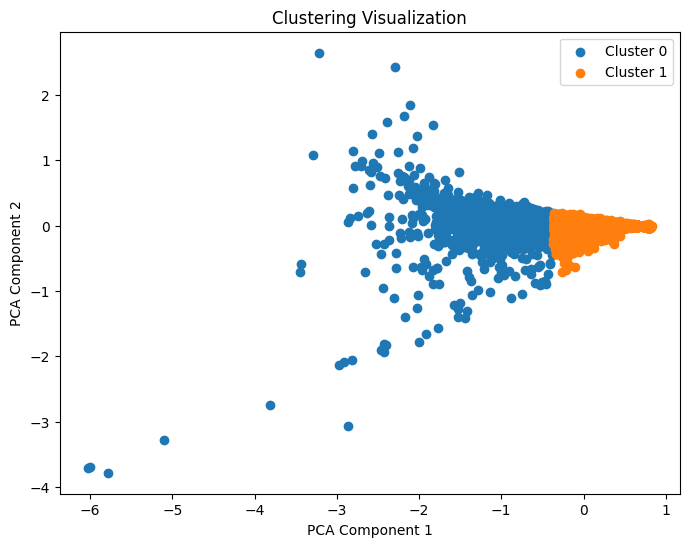

In [26]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embedding_matrix)

# Plot the clusters
plt.figure(figsize=(8, 6))
for cluster_id in range(n_clusters):
    cluster_points = reduced_embeddings[clusters == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}")
plt.title("Clustering Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import silhouette_score

silhouette = silhouette_score(embedding_matrix, clusters)
print("Silhouette Score:", silhouette)

Silhouette Score: 0.5971984


In [28]:
cluster_sizes = pd.Series(clusters).value_counts()
print("Cluster sizes:", cluster_sizes)

Cluster sizes: 1    8036
0    1873
Name: count, dtype: int64


The results are inadequate, and no clear pattern emerges from this method. Further investigation is needed, as the unsupervised approach appears to be less effective due to the lack of distinct clusters in the outcomes.